## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Removing previous trained models

In [ ]:
import os

dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
test = os.listdir(dir_name)

for item in test:
    if item.endswith('.h5'):
        print(f'deleting {item}')
        os.remove(os.path.join(dir_name, item))

deleting flipout_model_epochs_50_num_samples_20.h5


## Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

## Installing keras uncertainty

In [ ]:
# keras_uncertainty imports 
# clone and install this library 

!git clone https://github.com/mvaldenegro/keras-uncertainty.git
!pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git

%cd keras-uncertainty

fatal: destination path 'keras-uncertainty' already exists and is not an empty directory.
  Cloning https://github.com/mvaldenegro/keras-uncertainty.git to /tmp/pip-req-build-ki7q02_6
  Running command git clone -q https://github.com/mvaldenegro/keras-uncertainty.git /tmp/pip-req-build-ki7q02_6
/content/keras-uncertainty


## Keras uncertainty specific imports

In [ ]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import load_model
import random
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import keras_uncertainty
from keras_uncertainty.models import StochasticRegressor, TwoHeadStochasticRegressor
from keras_uncertainty.models.DeepEnsembleClassifier import DeepEnsemble

from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, StochasticDropout
from keras_uncertainty.metrics import gaussian_interval_score
from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True) 

import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

# 28022022 the code works without disabling the eager execution (dont know why) 

# if eager execution is not disabled following error occurs:
# TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), 
#dtype=tf.float32, name=None), name='Placeholder:0', description="created 
#by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, 
#to a TF API that does not allow registering custom dispatchers, 
#such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. 
#Keras Functional model construction only supports TF API calls that 
#*do* support dispatching, such as `tf.math.add` or `tf.reshape`. 
#Other APIs cannot be called directly on symbolic Kerasinputs/outputs. 
#You can work around this limitation by putting the operation in a custom 
#Keras layer `call` and calling that layer on this symbolic input/output. : 

Keras Uncertainty will use standalone Keras backend

## Load data

In [ ]:
# load the california housing data from csv
train_file = '/content/sample_data/california_housing_train.csv'
test_file = '/content/sample_data/california_housing_test.csv'

train_combined = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# split the data in validation and test (from test.csv)
train, val = train_test_split(train_combined, test_size=0.25)

feature_names = list(train_combined.columns)
print(feature_names)

# assign the target variable
target = 'median_house_value'

# extract the target label in all sets
train_labels_df= train[target]
val_labels_df = val[target]
test_labels_df = test[target]

# extract the data from all sets 
train_data_df = train.drop(columns=target, axis=1)
val_data_df = val.drop(columns=target, axis=1)
test_data_df = test.drop(columns=target, axis=1)

train_data_unnormalized = train_data_df.to_numpy()
train_labels_unnormalized = train_labels_df.to_numpy()

val_data_unnormalized = val_data_df.to_numpy()
val_labels_unnormalized = val_labels_df.to_numpy()

test_data_unnormalized = test_data_df.to_numpy()
test_labels_unnormalized = test_labels_df.to_numpy()

# normalize the data using minmax 
minmax = MinMaxScaler() 

train_data = minmax.fit_transform(train_data_unnormalized)
train_label_temp = np.expand_dims(train_labels_unnormalized, axis=1)
train_labels = minmax.fit_transform(train_label_temp)

val_data = minmax.fit_transform(val_data_unnormalized)
val_label_temp = np.expand_dims(val_labels_unnormalized, axis=1)
val_labels = minmax.fit_transform(val_label_temp)

test_data = minmax.fit_transform(test_data_unnormalized)
test_label_temp = np.expand_dims(test_labels_unnormalized, axis=1)
test_labels = minmax.fit_transform(test_label_temp)


print('Training data shape \n', train_data.shape)
print('Training labels shape \n', train_labels.shape)
#print('Training data \n ', train_data)
#print('Training labels \n ', train_labels)

print('Validation data shape \n ',val_data.shape)
print('Validation labels shape \n ', val_labels.shape)
#print('Validation data \n ', val_data)
#print('Validation labels \n ', val_labels)

print('Test data shape \n ', test_data.shape)
print('Test labels shape \n ', test_labels.shape)
#print('Test data \n ', test_data)
#print('Test labels \n ', test_labels)# load the california housing data from csv

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## StochasticModel

In [ ]:
import numpy as np

import keras_uncertainty.backend as K
Layer = K.layers.Layer
Dropout = K.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## FlipoutDense

In [ ]:
import numpy as np
import keras_uncertainty.backend as K
Layer = K.layers.Layer
activations = K.activations
initializers = K.initializers

from keras_uncertainty.distributions import gaussian, rademacher

# Code partially based on http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

class FlipoutDense(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 bias_distribution=False,
                  **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = rademacher.sample(input_shape)
        sign_output = rademacher.sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(gaussian.log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * gaussian.probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * gaussian.probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


399/399 - 13s - loss: 0.1159 - mae: 0.2008 - val_loss: 0.0602 - val_mae: 0.1981 - 13s/epoch - 31ms/step
Epoch 2/50
399/399 - 2s - loss: 0.1081 - mae: 0.1937 - val_loss: 0.0603 - val_mae: 0.1965 - 2s/epoch - 5ms/step
Epoch 3/50
399/399 - 2s - loss: 0.1080 - mae: 0.1938 - val_loss: 0.0598 - val_mae: 0.1942 - 2s/epoch - 5ms/step
Epoch 4/50
399/399 - 2s - loss: 0.1079 - mae: 0.1931 - val_loss: 0.0602 - val_mae: 0.1983 - 2s/epoch - 5ms/step
Epoch 5/50
399/399 - 2s - loss: 0.1082 - mae: 0.1937 - val_loss: 0.0598 - val_mae: 0.1971 - 2s/epoch - 6ms/step
Epoch 6/50
399/399 - 2s - loss: 0.1084 - mae: 0.1937 - val_loss: 0.0599 - val_mae: 0.1925 - 2s/epoch - 6ms/step
Epoch 7/50
399/399 - 2s - loss: 0.1080 - mae: 0.1932 - val_loss: 0.0604 - val_mae: 0.1967 - 2s/epoch - 5ms/step
Epoch 8/50
399/399 - 2s - loss: 0.1080 - mae: 0.1934 - val_loss: 0.0598 - val_mae: 0.1957 - 2s/epoch - 6ms/step
Epoch 9/50
399/399 - 2s - loss: 0.1078 - mae: 0.1938 - val_loss: 0.0603 - val_mae: 0.1937 - 2s/epoch - 5ms/step


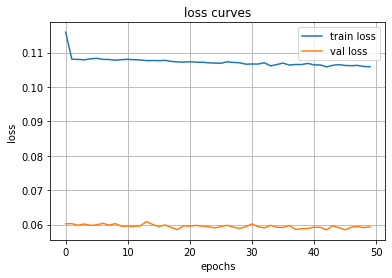

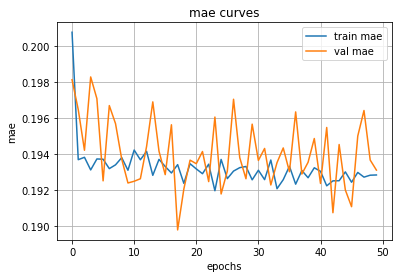

printing the model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flipout_dense (FlipoutDense  (None, 4)                72        
 )                                                               
                                                                 
 flipout_dense_1 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_2 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_3 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_4 (FlipoutDen 

In [ ]:
def train_flipout_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches
    prior_params = {
        'prior_sigma_1': 5.0, 
        'prior_sigma_2': 2.0, 
        'prior_pi': 0.5
    }

    model = Sequential()
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))

    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="relu", input_shape=(8,)))
    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="relu"))
    #model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="linear"))

    model.compile(loss='mse', optimizer='sgd', metrics=['mae'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)

    # plotting the training and validation curves
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    print('printing the model summary') 
    
    model.summary()
    model.save('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/flipout_model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5') 
    st_model = StochasticRegressor(model)
    pred_samples, pred_mean, pred_std = st_model.predict_output(x_test, num_samples=num_samples)

    return pred_samples, pred_mean, pred_std, st_model

epochs=50
num_samples=20
prob=0.1
# running this command creates the stochastic flipout model, trains it and generates the predicted_mean and predicted_std for the test set (all 3000 examples)
prediction_samples, prediction_mean, prediction_std, flipout_model = train_flipout_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples, prob=prob)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)

## Ground Truth vs prediction plot

In [ ]:
# Analysis of the input 
num_of_samples_to_be_explained = 1
start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)

pred_samples, pred_mean, pred_std = flipout_model.predict_output(test_data, num_samples=num_samples)
print(pred_mean.shape)
print(pred_std.shape)
print(pred_samples.shape)

start_index :  2517
test_input shape : (1, 8)
test_input_adj shape : (1, 8, 1)
(3000, 1)
(3000, 1)
(20, 3000, 1)


## Removing the previous plots and explanations

In [ ]:
import glob, os, os.path
mydir = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/'
filelist = glob.glob(os.path.join(mydir, "*.pdf"))
for f in filelist:
    print(f'removing file {f}')
    os.remove(f)

removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_0_input_id_2157.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_1_input_id_2157.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_2_input_id_2157.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_3_input_id_2157.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_4_input_id_2157.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_5_input_id_2157.pd

indices to be plotted 
 range(2171, 2271)


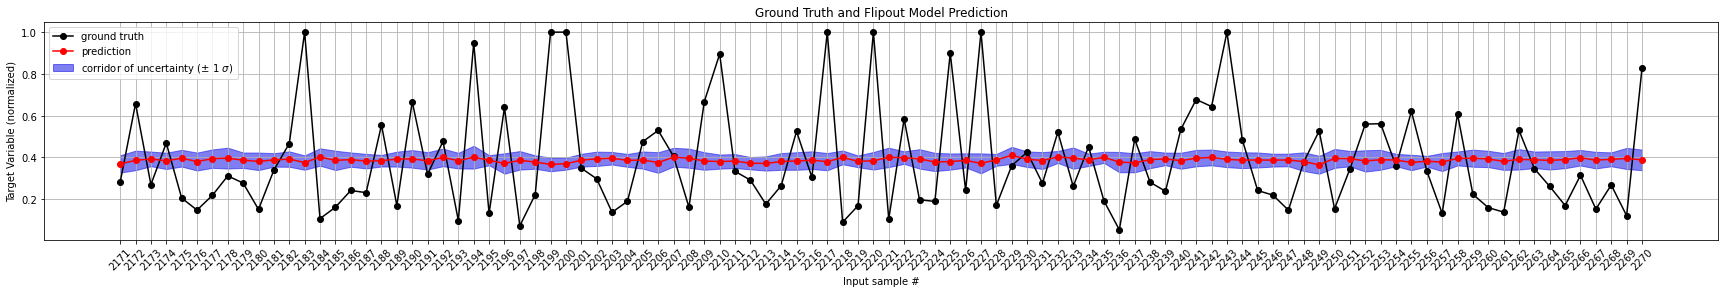

In [ ]:
# function to visualize the ground truth with the predicted value and (corridor of uncertainty)

def plot(ground_truth, prediction_mean, prediction_std, path, indices_to_be_plotted):
    plt.figure(figsize=(30, 4))
    plt.plot(range(ground_truth.shape[0]),  ground_truth, color='k', label='ground truth', marker='o')
    plt.plot(range(ground_truth.shape[0]), prediction_mean, color='r', label='prediction', marker='o')
   
    y_pred_mean = prediction_mean.reshape((-1,))
    y_pred_std = prediction_std.reshape((-1,))
    y_pred_up_1 = y_pred_mean + y_pred_std
    y_pred_down_1 = y_pred_mean - y_pred_std

    plt.fill_between(range(ground_truth.shape[0]), y_pred_down_1, y_pred_up_1, color=(0, 0, 0.9, 0.7), label='corridor of uncertainty ($\pm$ 1 $\sigma$) ', alpha=0.5)
    #plt.plot(range(ground_truth.shape[0]), y_pred_mean, '.', color=(0, 0.9, 0.0, 0.8), markersize=0.2, label='Mean')

    #plt.set_title('{}\nInterval Score: {:.2f}'.format(key, score))
    #plt.set_ylim([-20.0, 20.0])

    #plt.axvline(x=-4.0, color='black', linestyle='dashed')
    #plt.axvline(x= 4.0, color='black', linestyle='dashed')
    #plt.get_xaxis().set_ticks([])
    #plt.get_yaxis().set_ticks([])    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.grid()
    plt.xticks(range(len(indices_to_be_plotted)), indices_to_be_plotted, rotation=45)
    plt.xlabel('Input sample #')
    plt.ylabel('Target Variable (normalized)')
    plt.title('Ground Truth and Flipout Model Prediction')
    plt.savefig(path)
    plt.show()

start_index = np.random.randint(test_data.shape[0]-150)
random = range(start_index, start_index+100)
print('indices to be plotted \n', random)
test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
mean_flipout_plot = np.asarray([float(pred_mean[i]) for i in random])
std_flipout_plot = np.asarray([float(pred_std[i]) for i in random])

plot(test_labels_plot, mean_flipout_plot, std_flipout_plot, '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/flipout_gt_vs_prediction.pdf', random)

## Plot explanation function

In [ ]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, sample_number=None, err=None, save_file_path=None):
    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors) # this code appropriate legend
    
    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title('combined explanation')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)
        
        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    plt.subplots_adjust()
    plt.savefig(save_file_path+'.pdf')

## Compute GBP explanation

In [ ]:
# from captum ai website : understanding of guided backpropagation (source: https://captum.ai/api/guided_backprop.html)
# Computes attribution using guided backpropagation. Guided backpropagation computes the gradient of 
# the target output with respect to the input, but gradients of ReLU functions are overridden so that only non-negative gradients are backpropagated.

def gbp_explanation(test_input, layer_name, model, num_samples_explanations_to_be_generated, sample_id):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    feature_weight_list = [] 
    for i in range(num_samples_explanations_to_be_generated):
        print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
        print('Example to be explained : ' , test_input)
        with tf.GradientTape() as tape:
            inputs = tf.cast(test_input, tf.float32)
            tape.watch(inputs)
            # NO NEED TO RUN THIS (the if condition) AS VISUALIZATION OF ENSEMBLE HEATMAPS FOR INNER LAYER WOULD MAKE NO SENSE : FILTER IN EVERY INDIVIDUAL ENSEMBLE UNIT WOULD LEARN SOMETHING DIFFERENT EVERYTIMG
            # THIS THESIS NEEDS TO FOCUS ON FINAL LAYER HEATMAPS (AS THEY SHOULD BE SAME FOR A GIVEN INPUT ACROSS ENSEMBLES)
                    
            #outputs = gb_model.predict(inputs) 
            outputs = gb_model(inputs)
            # essentially model() and model.predict() yield the same output with the difference that 
            # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
            #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
            #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()

    
            print('feature_names ', feature_names)
            print('outputs ', outputs)

            grads = tape.gradient(outputs, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
            print('grads ', grads)

            grads = grads.numpy() #as the model(inputs) returns a tensor and this is eventually used in the gradient computation, for plotting purpose this needs to be converted in np

            # normalizing the value of computed gradient for each feature [04032022 update : no need to normalize the gradients as it is only useful for visualization in heatmap ]
            # in bar charts, the gradients can remain negative 
            #grads -= np.min(grads)
            #grads /= np.max(grads)
        
        print('normalized_grads : ', grads)
        feature_weight_list.append(grads)
        plot_explanation(grads_plot=grads, 
                         sample_number=i, 
                         err=None, 
                         save_file_path='/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(sample_id))   
    
    print('feature_weight_list : ', feature_weight_list)
    feature_weight_arr =  np.asarray(feature_weight_list)
    feature_weight = np.reshape(feature_weight_arr, (num_samples_explanations_to_be_generated, -1))
    # the mean and the std of the different explanations of the samples is computed here 
    mean_feature_weight = np.mean(feature_weight_arr, axis=0)
    std_feature_weight = np.std(feature_weight_arr, axis=0)

    #print(mean_feature_weight)
    #print(std_feature_weight)

    

    plot_explanation(grads_plot=mean_feature_weight, 
                     sample_number=None, 
                     err=std_feature_weight,
                     save_file_path='/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/combined_explanation_of_'+str(num_samples_explanations_to_be_generated)+'_samples_for_input_id_'+str(sample_id))
    
    return mean_feature_weight, std_feature_weight

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flipout_dense (FlipoutDense  (None, 4)                72        
 )                                                               
                                                                 
 flipout_dense_1 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_2 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_3 (FlipoutDen  (None, 4)                40        
 se)                                                             
                                                                 
 flipout_dense_4 (FlipoutDen  (None, 4)                4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.07980729  0.04200738 -0.0770736   0.14113405]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.01876416 -0.00763569  0.00405329  0.00626269 -0.04024298  0.00756325
  0.00077743  0.01380426], shape=(8,), dtype=float32)
normalized_grads :  [-0.01876416 -0.00763569  0.00405329  0.00626269 -0.04024298  0.00756325
  0.00077743  0.01380426]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.16612664  0.12295532 -0.16880207  0.01175216]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.02211116 -0.00049488 -0.00245875  0.01419168 -0.03094389  0.00984454
 -0.00070375  0.00798013], shape=(8,), dtype=float32)
normalized_grads :  [-0.02211116 -0.00049488 -0.00245875  0.01419168 -0.03094389  0.00984454
 -0.00070375  0.00798013]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.23176943  0.15116882 -0.02000807  0.07757853]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00893495  0.01401739 -0.01278855  0.0377094  -0.05156329  0.01000772
  0.02779873  0.00470601], shape=(8,), dtype=float32)
normalized_grads :  [-0.00893495  0.01401739 -0.01278855  0.0377094  -0.05156329  0.01000772
  0.02779873  0.00470601]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.0877632   0.15663959 -0.08460325  0.17042601]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.02361325  0.00122251  0.00372017  0.01424007 -0.02359413  0.01058686
  0.01325504  0.01663849], shape=(8,), dtype=float32)
normalized_grads :  [-0.02361325  0.00122251  0.00372017  0.01424007 -0.02359413  0.01058686
  0.01325504  0.01663849]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.12421303  0.06770017 -0.185179    0.1555922 ]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00834042 -0.01197929 -0.00794475  0.01800493 -0.01851403 -0.0036366
 -0.00506329  0.01275657], shape=(8,), dtype=float32)
normalized_grads :  [-0.00834042 -0.01197929 -0.00794475  0.01800493 -0.01851403 -0.0036366
 -0.00506329  0.01275657]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.15358283  0.1122491  -0.18929902  0.08619437]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00278803 -0.01265757 -0.00148204  0.00719227 -0.01699429  0.00285577
  0.00474389 -0.00249993], shape=(8,), dtype=float32)
normalized_grads :  [-0.00278803 -0.01265757 -0.00148204  0.00719227 -0.01699429  0.00285577
  0.00474389 -0.00249993]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.13153777  0.2239924  -0.15797572  0.09721644]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00923684 -0.01391011 -0.00941355  0.01248074 -0.0150724  -0.00094101
  0.01080807 -0.00001759], shape=(8,), dtype=float32)
normalized_grads :  [-0.00923684 -0.01391011 -0.00941355  0.01248074 -0.0150724  -0.00094101
  0.01080807 -0.00001759]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.20822488 -0.0057555  -0.29405978  0.17510709]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00238896 -0.00809961 -0.01830931  0.01603394 -0.02072214  0.00721992
  0.00190466  0.01140594], shape=(8,), dtype=float32)
normalized_grads :  [-0.00238896 -0.00809961 -0.01830931  0.01603394 -0.02072214  0.00721992
  0.00190466  0.01140594]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.23776259  0.06546565 -0.0819877   0.09844397]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[ 0.01405671  0.00189867 -0.02175315  0.03428689 -0.02969443  0.00331583
  0.01935613  0.0025201 ], shape=(8,), dtype=float32)
normalized_grads :  [ 0.01405671  0.00189867 -0.02175315  0.03428689 -0.02969443  0.00331583
  0.01935613  0.0025201 ]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.17474858  0.12597582 -0.12466373  0.12204863]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[ 0.01722841 -0.00941589 -0.04091407  0.05616667 -0.03458408  0.01836121
  0.0194868   0.01851954], shape=(8,), dtype=float32)
normalized_grads :  [ 0.01722841 -0.00941589 -0.04091407  0.05616667 -0.03458408  0.01836121
  0.0194868   0.01851954]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.15623187  0.11469787 -0.13566764  0.02544948]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00666392 -0.00215847  0.00129276  0.01073518 -0.01711454  0.00704472
  0.0073967   0.00369989], shape=(8,), dtype=float32)
normalized_grads :  [-0.00666392 -0.00215847  0.00129276  0.01073518 -0.01711454  0.00704472
  0.0073967   0.00369989]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.16126052  0.12600136 -0.08934233  0.09529977]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[ 0.00690391 -0.00973105 -0.00506765  0.04300245 -0.01962869  0.01441778
  0.020804    0.00878018], shape=(8,), dtype=float32)
normalized_grads :  [ 0.00690391 -0.00973105 -0.00506765  0.04300245 -0.01962869  0.01441778
  0.020804    0.00878018]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.15722744  0.03220965 -0.11741012 -0.04866582]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.00719739 -0.00016416  0.00105338  0.01201846 -0.0167308   0.00347277
  0.00887013  0.00608429], shape=(8,), dtype=float32)
normalized_grads :  [-0.00719739 -0.00016416  0.00105338  0.01201846 -0.0167308   0.00347277
  0.00887013  0.00608429]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.11566111  0.11887051 -0.03665958  0.05273846]], shape=(1, 4), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


grads  tf.Tensor(
[-0.00108712 -0.00497248  0.00181505  0.0130201  -0.02881286  0.01033238
  0.01654337  0.00409198], shape=(8,), dtype=float32)
normalized_grads :  [-0.00108712 -0.00497248  0.00181505  0.0130201  -0.02881286  0.01033238
  0.01654337  0.00409198]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.14208034  0.08041886 -0.20413993  0.14474006]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[ 0.00265399  0.0028111  -0.02413265  0.03633977 -0.02853137 -0.00358257
  0.00966471  0.02017425], shape=(8,), dtype=float32)
normalized_grads :  [ 0.00265399  0.0028111  -0.02413265  0.03633977 -0.02853137 -0.00358257
  0.00966471  0.02017425]
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.22011292  0.12345541 -0.08893947  0.08289389]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.0051893  -0.00647423 -0.00897318  0.005766   -0.03219157  0.02091128
  0.02244668  0.01559839], shape=(8,), dtype=float32)
normalized_grads :  [-0.0051893  -0.00647423 -0.00897318  0.005766   -0.03219157  0.02091128
  0.02244668  0.01559839]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[-0.00133097  0.0954657  -0.16939043  0.04338956]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.01869112 -0.0114579  -0.00895466  0.00569621 -0.01437374  0.00402512
  0.00981772 -0.00596075], shape=(8,), dtype=float32)
normalized_grads :  [-0.01869112 -0.0114579  -0.00895466  0.00569621 -0.01437374  0.00402512
  0.00981772 -0.00596075]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[0.23426213 0.50106838 0.58823529 0.06365786 0.06294997 0.08130763
  0.06737013 0.30486476]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor([[ 0.18675171  0.00865089 -0.12598349  0.17997114]], shape=(1, 4), dtype=float32)
grads  tf.Tensor(
[-0.01152296  0.01130908  0.00743086  0.02174298 -0.02921154  0.00856603
  0.02104635 -0.00562517], shape=(8,), dtype=float32)
normalized_grads :  [-0.01152296  0.01130908  0.00743086  0.02174298 -0.02921154  0.00856603
  0.02104635 -0.00562517]
feature_weight_list :  [array([-0.01675996,  0.00892785, -0.01547117,  0.02032992, -0.01255458,
       -0.00376518,  0.00828419,  0.00798309], dtype=float32), array([-0.01876416, -0.00763569,  0.00405329,  0.00626269, -0.04024298,
        0.00756325,  0.00077743,  0.01380426], dtype=float32), array([-0.02211116, -0.0004948

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


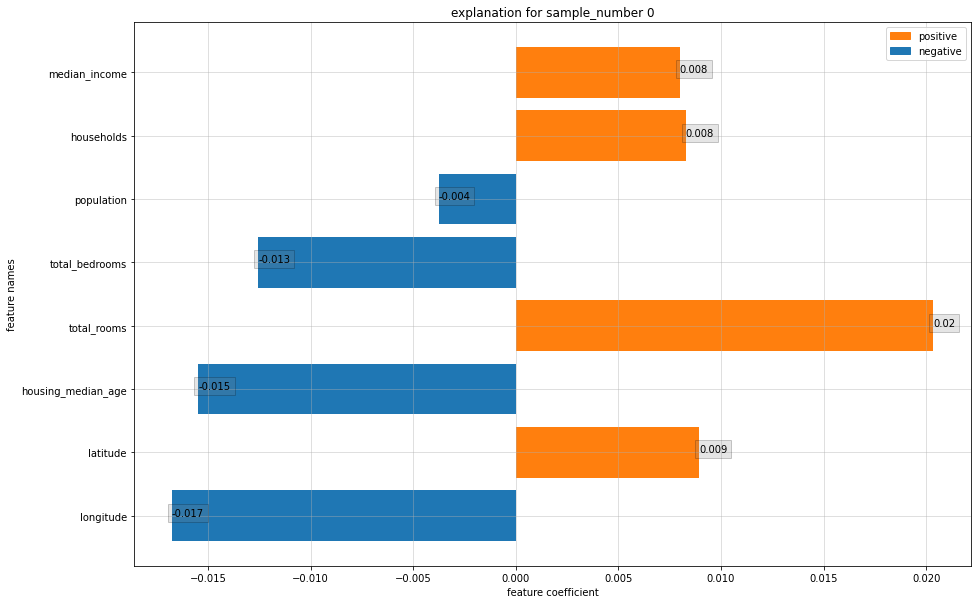

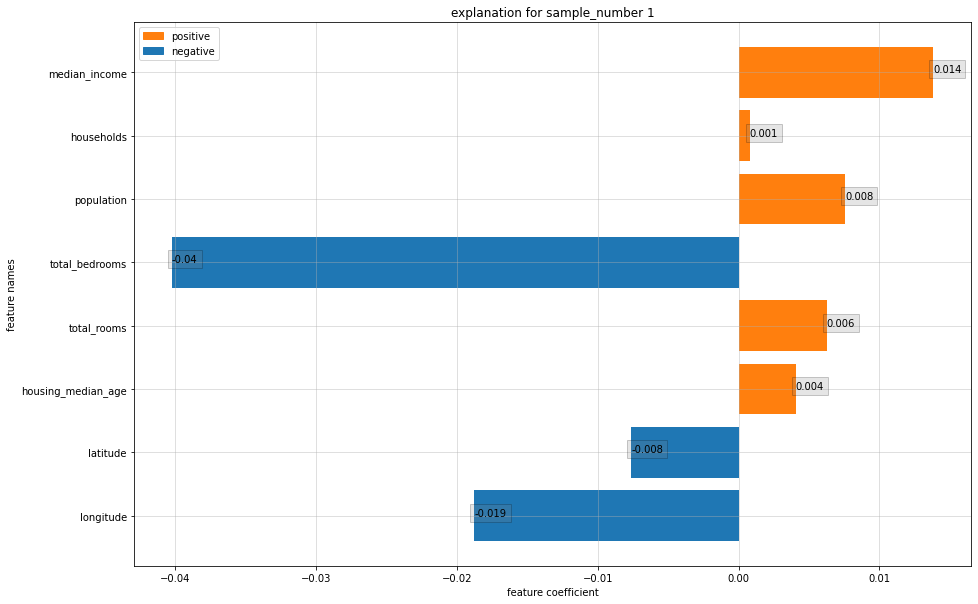

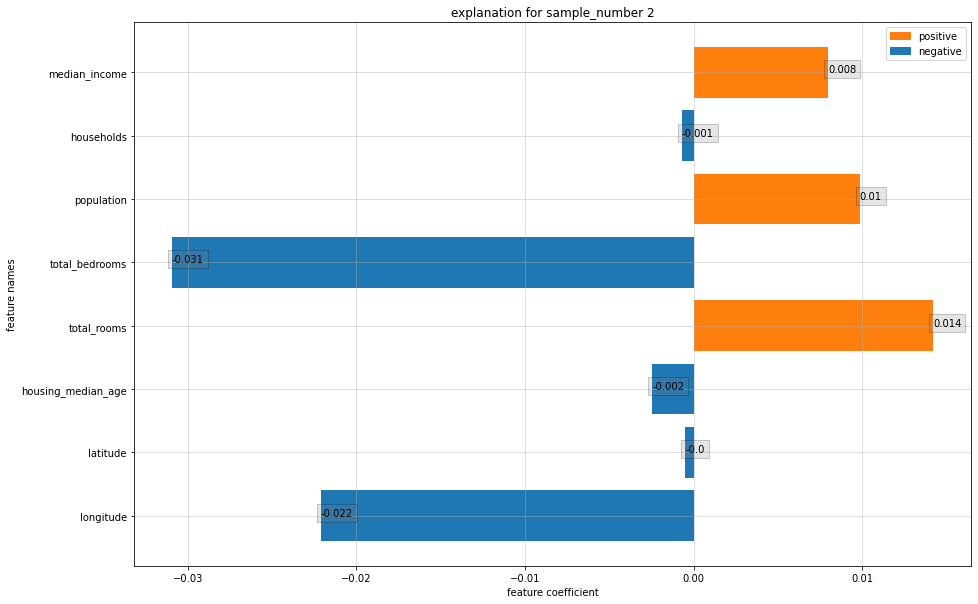

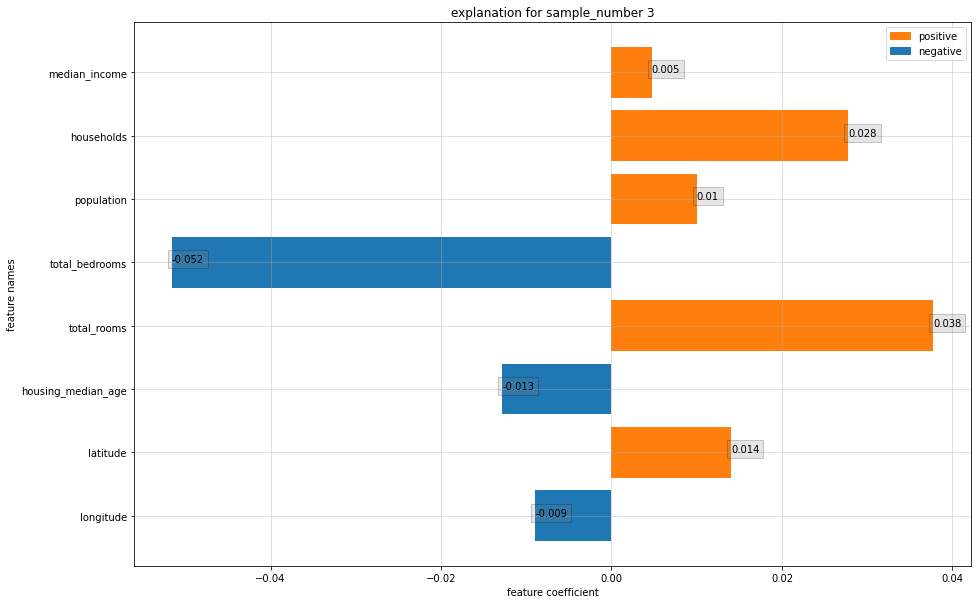

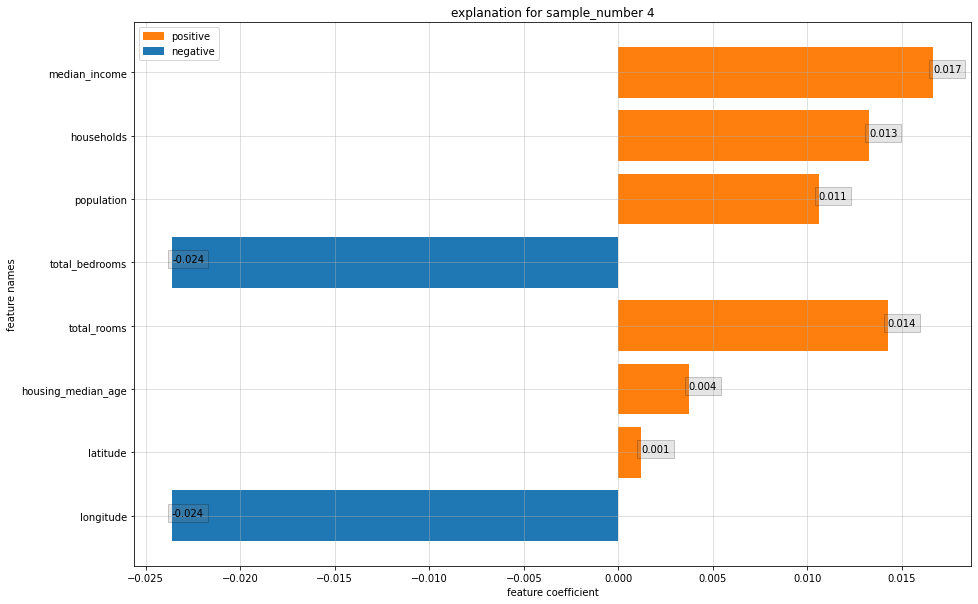

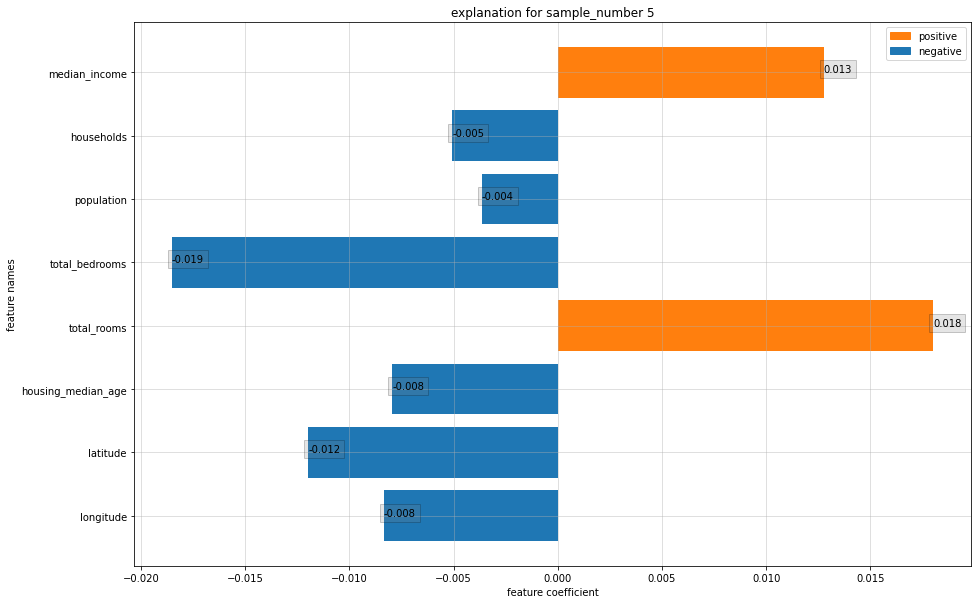

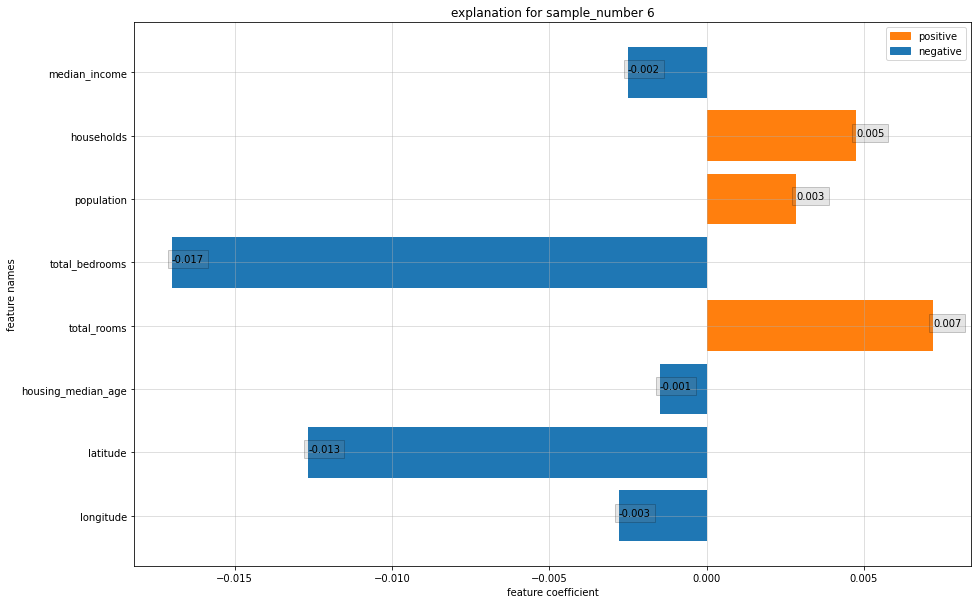

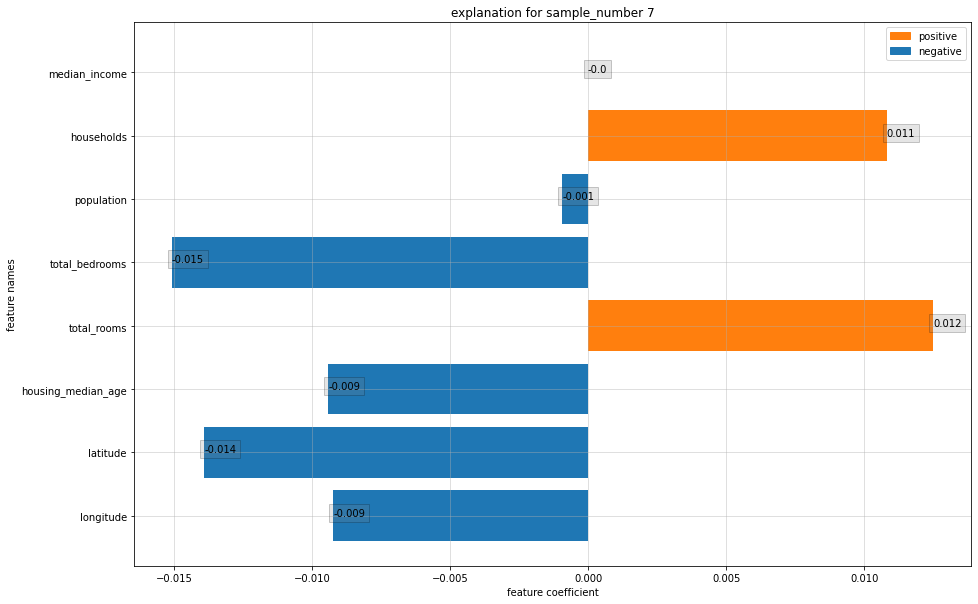

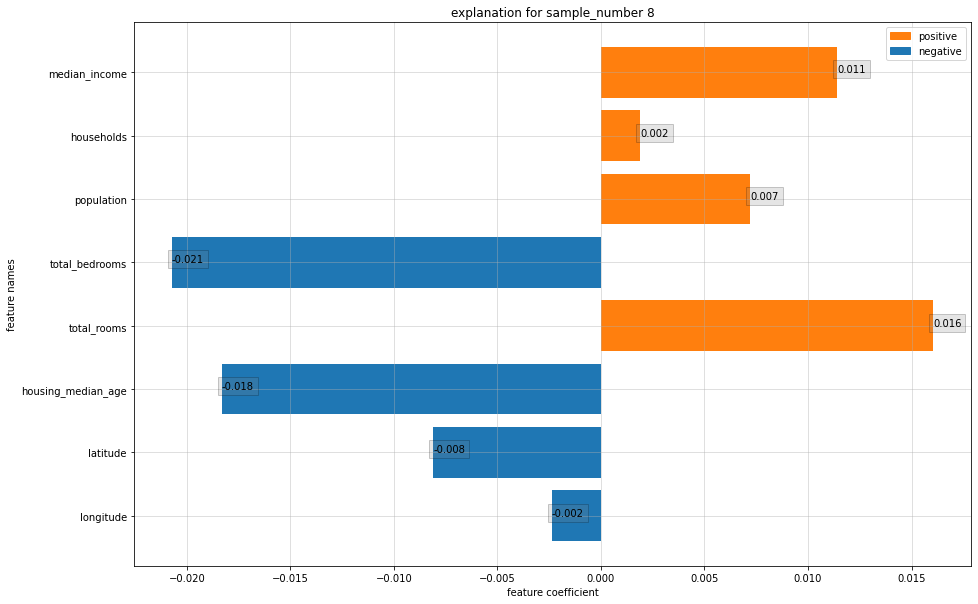

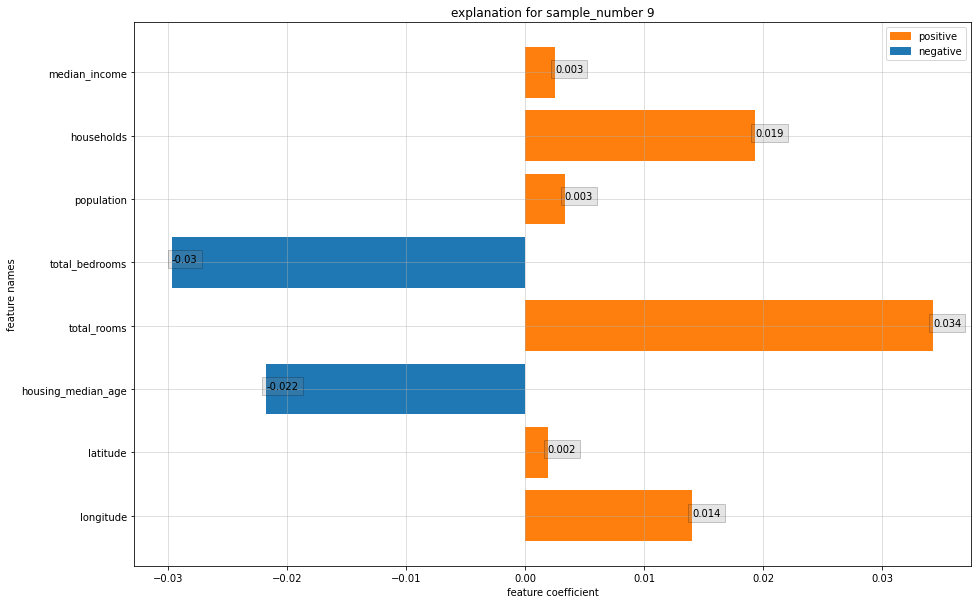

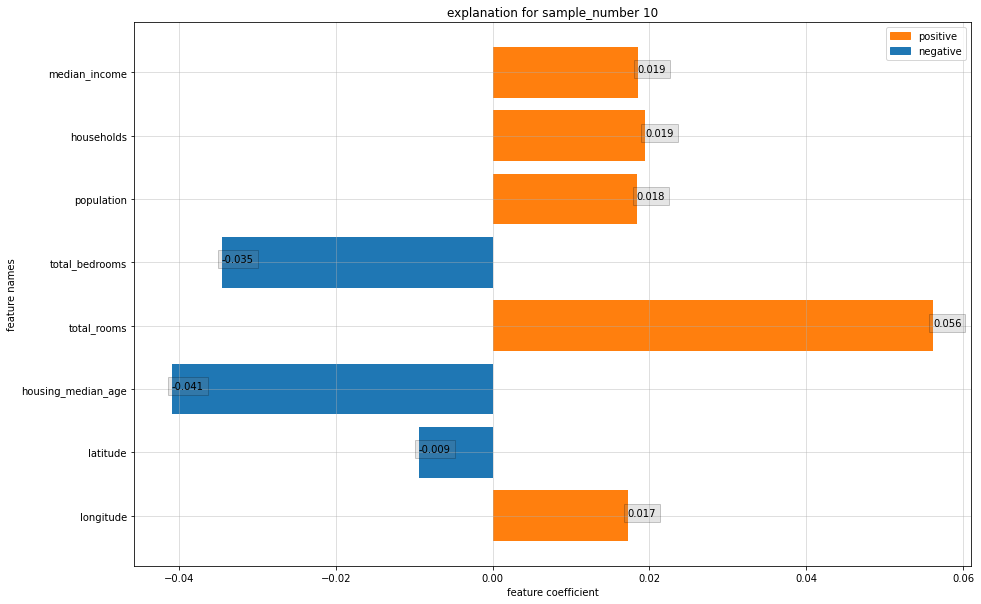

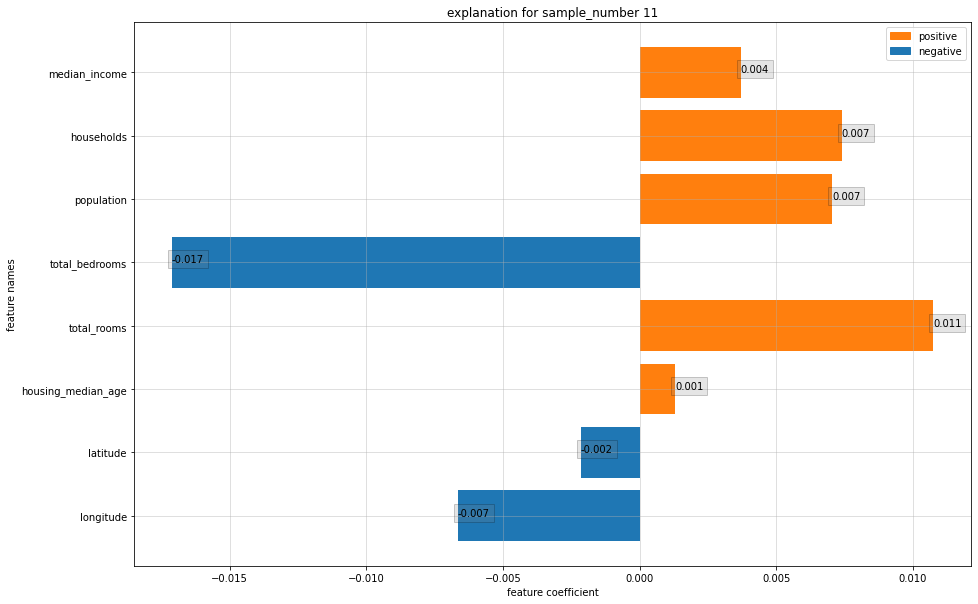

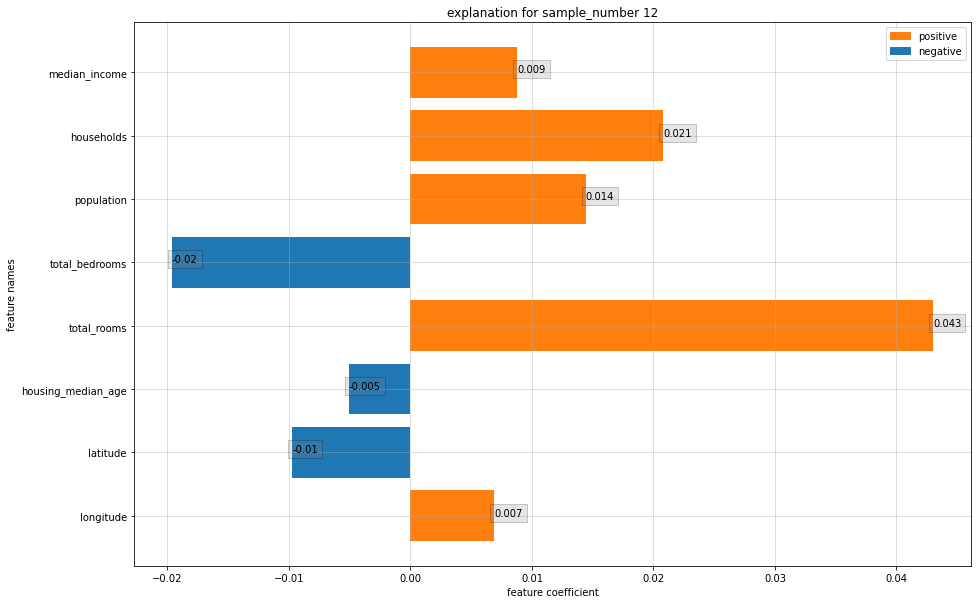

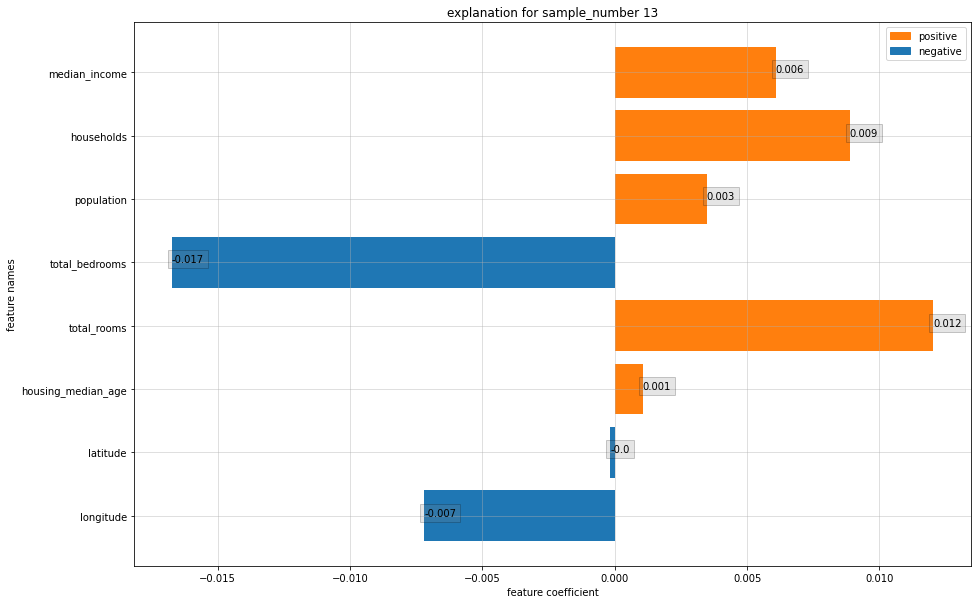

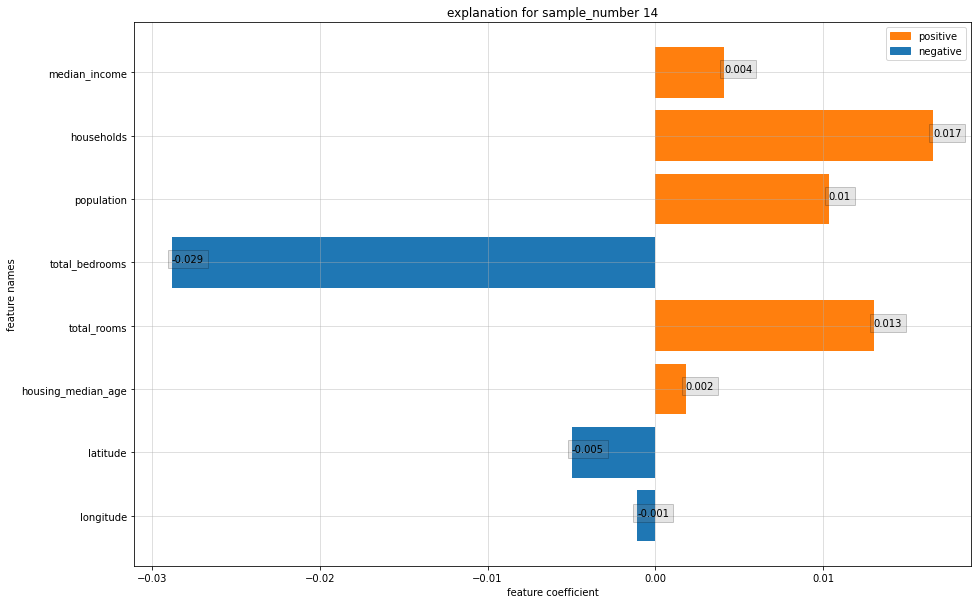

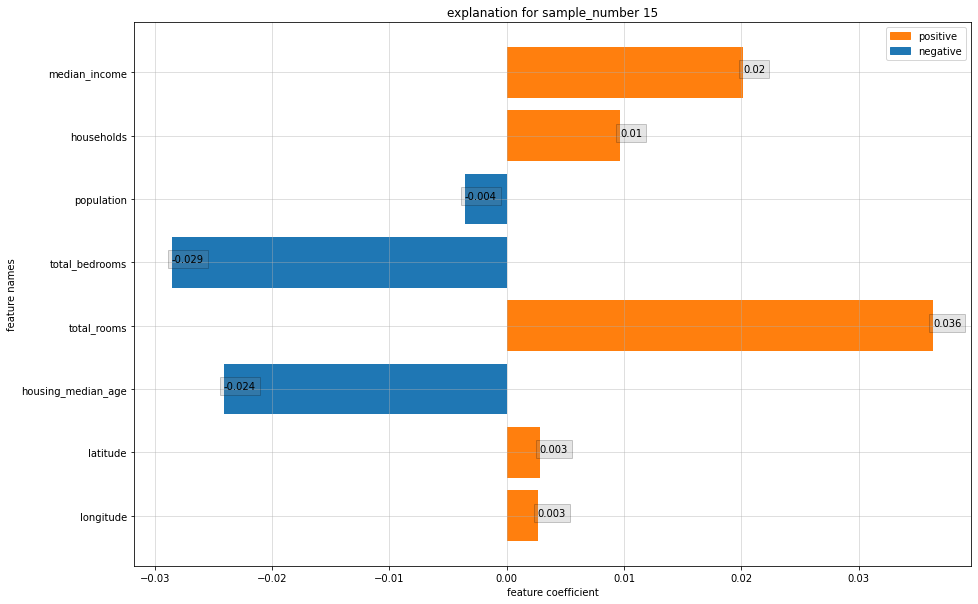

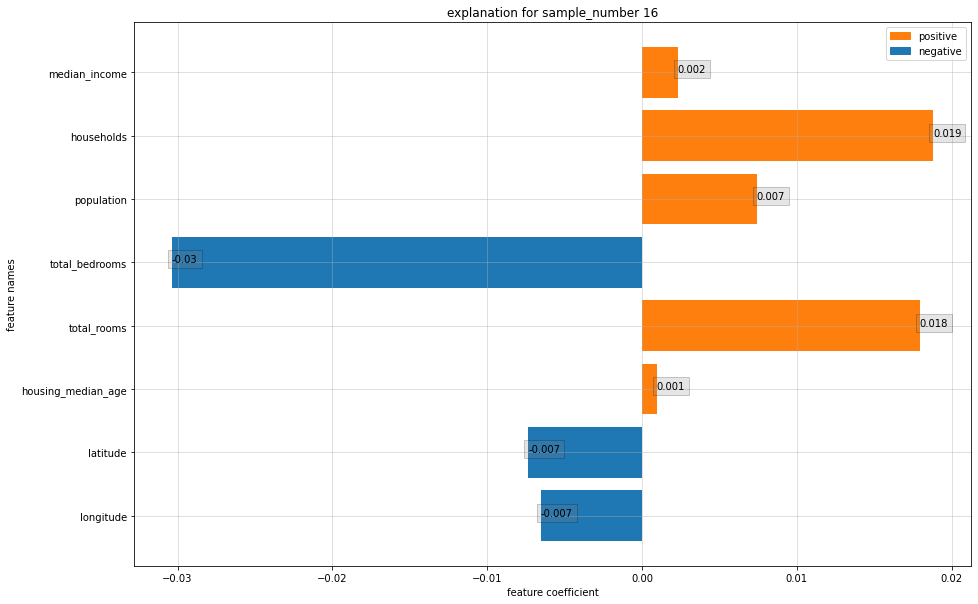

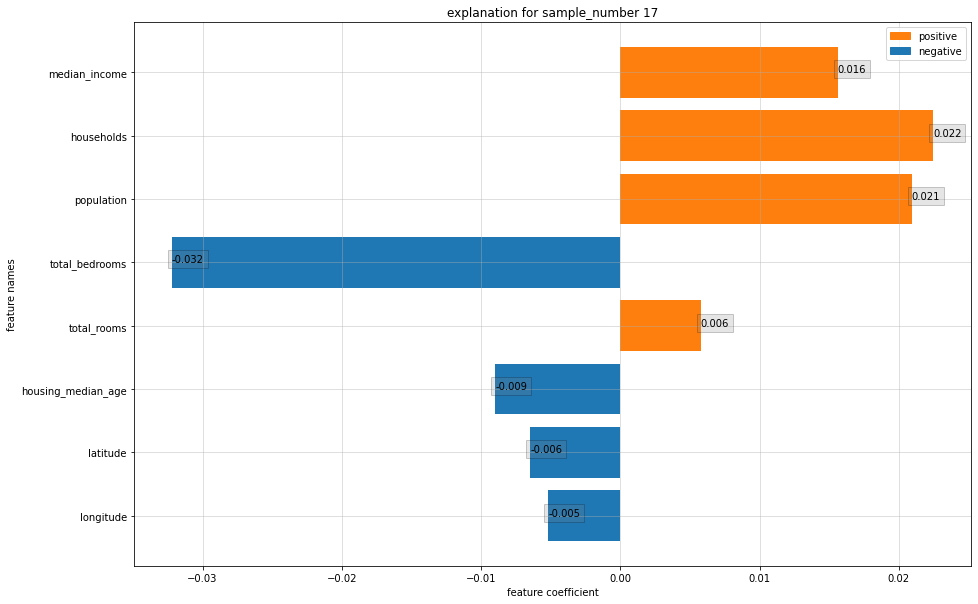

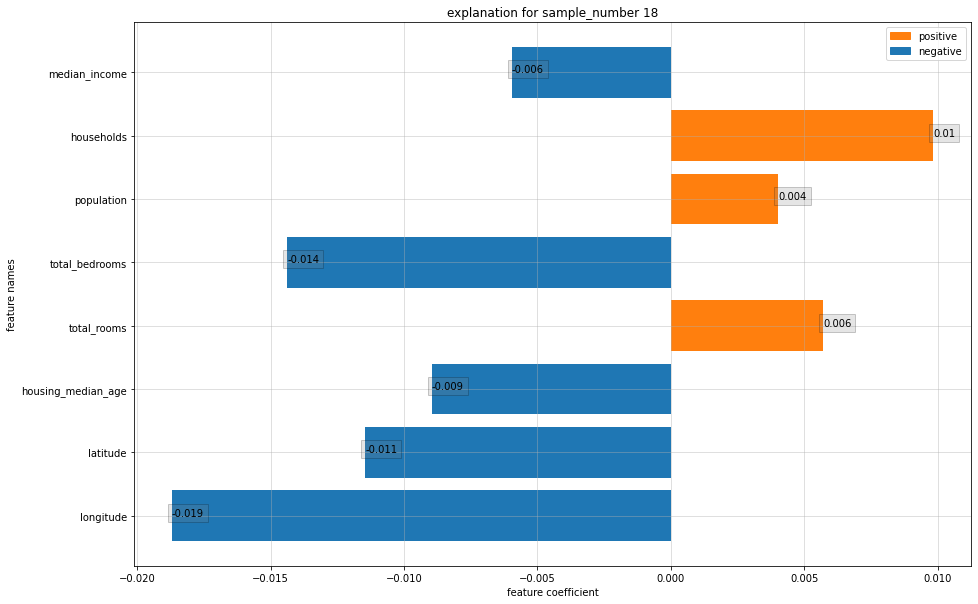

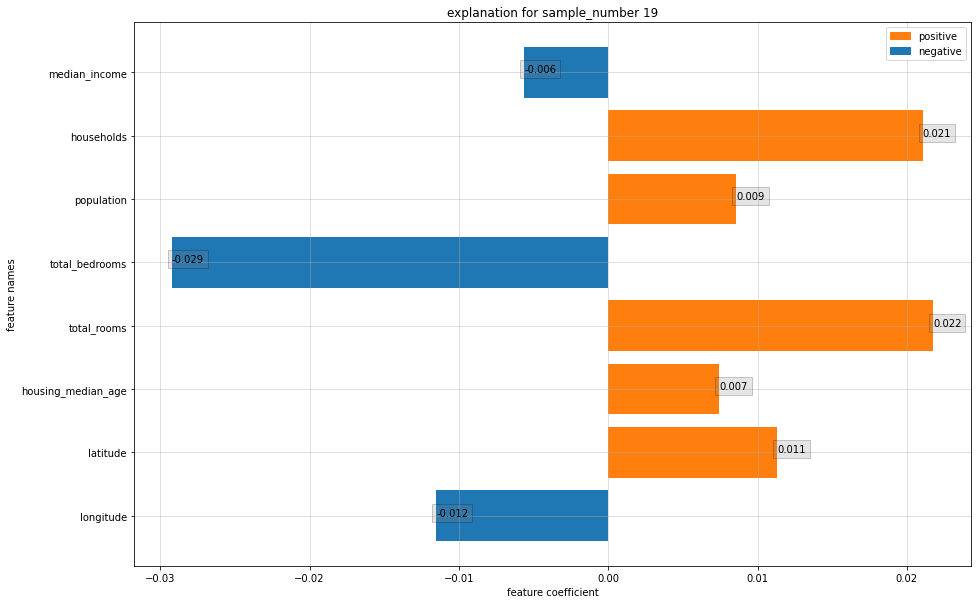

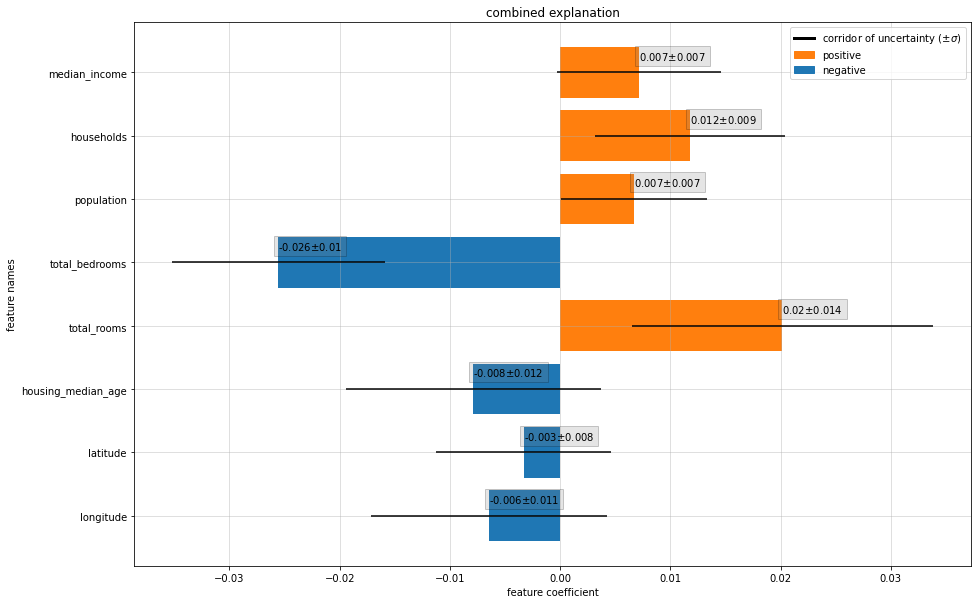

In [ ]:
flipout_model.summary()
# Analysis of the input 
test_sample_index=np.random.randint(3000)
test_input_temp = test_data[test_sample_index]
test_input = np.expand_dims(test_input_temp, axis=0)
print('test_input shape :', test_input.shape)
mean_feature_weight, std_feature_weight = gbp_explanation(test_input, 
                                                          'flipout_dense_2',
                                                          flipout_model, 
                                                          num_samples_explanations_to_be_generated=20,
                                                          sample_id=test_sample_index)

mean_feature_weight  [-0.00644945 -0.00331569 -0.00786754  0.02015802 -0.02557179  0.00670077
  0.01180132  0.00714666]
std_feature_weight  [0.01071015 0.00793268 0.01155105 0.01365675 0.00963859 0.00661835
 0.00861755 0.00745368]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
coefficient_of_variation  [-166.06286764144897, -239.2467737197876, -146.81918621063232, 67.74851083755493, -37.692272663116455, 98.76998662948608, 73.02194833755493, 104.29612398147583]


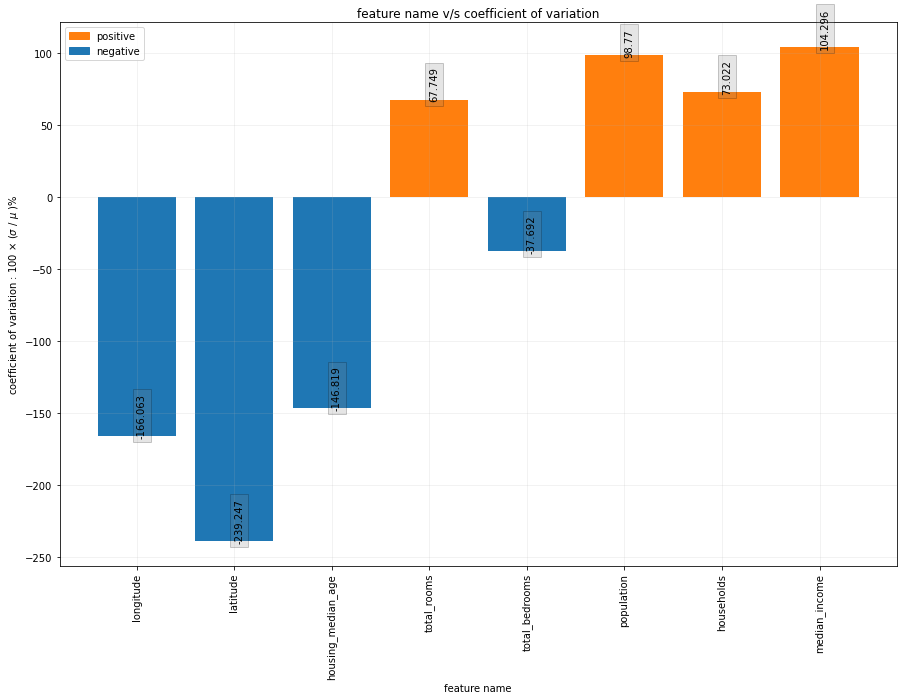

In [ ]:
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

print('mean_feature_weight ', mean_feature_weight)
print('std_feature_weight ', std_feature_weight)
print('feature_names ', feature_names)

eps=1e-3
# compute coefficient of variation 
coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(std_feature_weight, mean_feature_weight)]
print('coefficient_of_variation ', coefficient_of_variation)


plt.figure(figsize=(15, 10))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
plt.grid(alpha=0.2) 


plt.legend(handles, labels)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i, v, str(round(v, 3)), rotation=90, Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

plt.savefig('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.pdf', bbox_inches='tight')

#https://en.wikipedia.org/wiki/Kurtosis